In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Fri Jan 15 12:55:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   33C    P0    31W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import All_CNN6Layer_A as ModelA
from model.models_mjp_19November20 import All_CNN6Layer_E as ModelE
from model.models_mjp_19November20 import All_CNN8Layer_W as ModelW
from model.models_mjp_26December20 import All_CNN10Layer_X as ModelX
from model.models_mjp_26December20 import All_CNN8Layer_Y as ModelY

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1000, 1e-3, 420)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 10.84 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 10.33 s
Constructing 160000 event dataset took 3.338 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.54 s
Constructing 9984 event dataset took 0.05915 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelY()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/696019a572414cf18a495f23dfc016e7/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 28.0 parameter layers to update in the current model, 28.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN8Layer_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(71, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=Tru

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


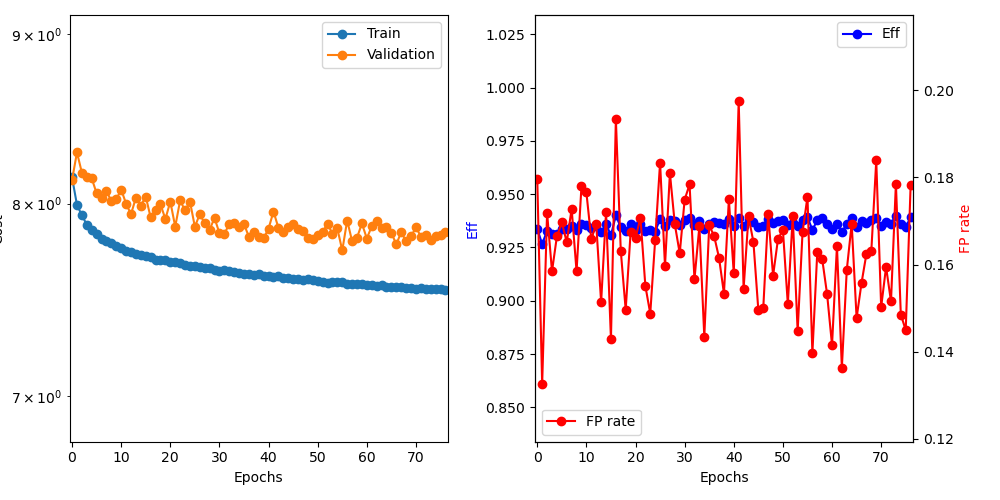

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
avgEff = 0.0
avgFP = 0.0
print('for model: ', model)   
run_name = 'ACNN Y (P4)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  All_CNN8Layer_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(71, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 420: train=8.14704, val=8.13191, took 149.18 s
  Validation Found 50896 of 54504, added 1794 (eff 93.38%) (0.18 FP/event)
Result epoch:  420
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 421: train=7.99331, val=8.28998, took 148.86 s
  Validation Found 50501 of 54504, added 1324 (eff 92.66%) (0.133 FP/event)
Result epoch:  421
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 422: train=7.93536, val=8.17376, took 149.41 s
  Validation Found 50844 of 54504, added 1716 (eff 93.28%) (0.172 FP/event)
Result epoch:  422
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 423: train=7.88467, val=8.15067, took 150.68 s
  Validation Found 50757 of 54504, added 1582 (eff 93.13%) (0.158 FP/event)
Result epoch:  423
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 424: train=7.85293, val=8.1425, took 150.38 s
  Validation Found 50765 of 54504, added 1662 (eff 93.14%) (0.166 FP/event)
Result epoch:  424
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 425: train=7.83403, val=8.05766, took 150.17 s
  Validation Found 50883 of 54504, added 1694 (eff 93.36%) (0.17 FP/event)
Result epoch:  425
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 426: train=7.80639, val=8.0308, took 150.34 s
  Validation Found 50882 of 54504, added 1649 (eff 93.35%) (0.165 FP/event)
Result epoch:  426
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 427: train=7.79465, val=8.07233, took 150.02 s
  Validation Found 50977 of 54504, added 1725 (eff 93.53%) (0.173 FP/event)
Result epoch:  427
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 428: train=7.78184, val=8.01258, took 149.43 s
  Validation Found 50861 of 54504, added 1582 (eff 93.32%) (0.158 FP/event)
Result epoch:  428
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 429: train=7.76671, val=8.02375, took 150.15 s
  Validation Found 51018 of 54504, added 1777 (eff 93.60%) (0.178 FP/event)
Result epoch:  429
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 430: train=7.75734, val=8.07864, took 150.24 s
  Validation Found 50982 of 54504, added 1763 (eff 93.54%) (0.177 FP/event)
Result epoch:  430
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 431: train=7.74131, val=7.99984, took 149.5 s
  Validation Found 50925 of 54504, added 1655 (eff 93.43%) (0.166 FP/event)
Result epoch:  431
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 432: train=7.7344, val=7.94133, took 150.11 s
  Validation Found 50986 of 54504, added 1691 (eff 93.55%) (0.169 FP/event)
Result epoch:  432
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 433: train=7.72712, val=8.03376, took 150.59 s
  Validation Found 50819 of 54504, added 1511 (eff 93.24%) (0.151 FP/event)
Result epoch:  433
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 434: train=7.7219, val=7.98973, took 149.76 s
  Validation Found 51009 of 54504, added 1717 (eff 93.59%) (0.172 FP/event)
Result epoch:  434
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 435: train=7.71615, val=8.03965, took 149.85 s
  Validation Found 50726 of 54504, added 1427 (eff 93.07%) (0.143 FP/event)
Result epoch:  435
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 436: train=7.70751, val=7.92385, took 150.26 s
  Validation Found 51234 of 54504, added 1931 (eff 94.00%) (0.193 FP/event)
Result epoch:  436
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 437: train=7.69554, val=7.96464, took 149.47 s
  Validation Found 50931 of 54504, added 1629 (eff 93.44%) (0.163 FP/event)
Result epoch:  437
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 438: train=7.69215, val=7.99627, took 149.78 s
  Validation Found 50833 of 54504, added 1494 (eff 93.26%) (0.15 FP/event)
Result epoch:  438
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 439: train=7.69069, val=7.91497, took 150.32 s
  Validation Found 51007 of 54504, added 1671 (eff 93.58%) (0.167 FP/event)
Result epoch:  439
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 440: train=7.68465, val=8.01184, took 149.63 s
  Validation Found 50866 of 54504, added 1658 (eff 93.33%) (0.166 FP/event)
Result epoch:  440
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 441: train=7.68255, val=7.87294, took 149.65 s
  Validation Found 51025 of 54504, added 1705 (eff 93.62%) (0.171 FP/event)
Result epoch:  441
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 442: train=7.67759, val=8.01823, took 150.52 s
  Validation Found 50833 of 54504, added 1549 (eff 93.26%) (0.155 FP/event)
Result epoch:  442
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 443: train=7.66588, val=7.96222, took 149.83 s
  Validation Found 50851 of 54504, added 1485 (eff 93.30%) (0.149 FP/event)
Result epoch:  443
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 444: train=7.66387, val=8.01198, took 149.48 s
  Validation Found 50818 of 54504, added 1654 (eff 93.24%) (0.166 FP/event)
Result epoch:  444
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 445: train=7.65978, val=7.87263, took 150.2 s
  Validation Found 51148 of 54504, added 1831 (eff 93.84%) (0.183 FP/event)
Result epoch:  445
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 446: train=7.65372, val=7.94234, took 150.04 s
  Validation Found 50972 of 54504, added 1594 (eff 93.52%) (0.16 FP/event)
Result epoch:  446
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 447: train=7.64845, val=7.89116, took 149.4 s
  Validation Found 51125 of 54504, added 1807 (eff 93.80%) (0.181 FP/event)
Result epoch:  447
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 448: train=7.6491, val=7.85653, took 149.98 s
  Validation Found 51093 of 54504, added 1690 (eff 93.74%) (0.169 FP/event)
Result epoch:  448
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 449: train=7.64072, val=7.92121, took 150.07 s
  Validation Found 50980 of 54504, added 1623 (eff 93.53%) (0.163 FP/event)
Result epoch:  449
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 450: train=7.63709, val=7.83741, took 149.34 s
  Validation Found 51119 of 54504, added 1746 (eff 93.79%) (0.175 FP/event)
Result epoch:  450
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 451: train=7.64059, val=7.8327, took 149.86 s
  Validation Found 51164 of 54504, added 1781 (eff 93.87%) (0.178 FP/event)
Result epoch:  451
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 452: train=7.63539, val=7.88902, took 150.28 s
  Validation Found 50993 of 54504, added 1564 (eff 93.56%) (0.157 FP/event)
Result epoch:  452
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 453: train=7.6299, val=7.89075, took 149.27 s
  Validation Found 51090 of 54504, added 1685 (eff 93.74%) (0.169 FP/event)
Result epoch:  453
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 454: train=7.62478, val=7.87037, took 149.76 s
  Validation Found 50896 of 54504, added 1432 (eff 93.38%) (0.143 FP/event)
Result epoch:  454
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 455: train=7.62137, val=7.88737, took 150.1 s
  Validation Found 51014 of 54504, added 1687 (eff 93.60%) (0.169 FP/event)
Result epoch:  455
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 456: train=7.61799, val=7.81781, took 149.43 s
  Validation Found 51077 of 54504, added 1663 (eff 93.71%) (0.167 FP/event)
Result epoch:  456
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 457: train=7.61414, val=7.84296, took 149.6 s
  Validation Found 51032 of 54504, added 1613 (eff 93.63%) (0.162 FP/event)
Result epoch:  457
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 458: train=7.62006, val=7.81937, took 150.19 s
  Validation Found 51006 of 54504, added 1531 (eff 93.58%) (0.153 FP/event)
Result epoch:  458
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 459: train=7.60935, val=7.81027, took 149.59 s
  Validation Found 51151 of 54504, added 1747 (eff 93.85%) (0.175 FP/event)
Result epoch:  459
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 460: train=7.60991, val=7.86275, took 149.54 s
  Validation Found 50974 of 54504, added 1577 (eff 93.52%) (0.158 FP/event)
Result epoch:  460
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 461: train=7.60426, val=7.95646, took 150.22 s
  Validation Found 51169 of 54504, added 1972 (eff 93.88%) (0.197 FP/event)
Result epoch:  461
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 462: train=7.60996, val=7.8676, took 149.77 s
  Validation Found 50972 of 54504, added 1542 (eff 93.52%) (0.154 FP/event)
Result epoch:  462
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 463: train=7.59547, val=7.84527, took 149.39 s
  Validation Found 51119 of 54504, added 1708 (eff 93.79%) (0.171 FP/event)
Result epoch:  463
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 464: train=7.59752, val=7.872, took 150.07 s
  Validation Found 51055 of 54504, added 1649 (eff 93.67%) (0.165 FP/event)
Result epoch:  464
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 465: train=7.59417, val=7.88789, took 149.96 s
  Validation Found 50948 of 54504, added 1493 (eff 93.48%) (0.15 FP/event)
Result epoch:  465
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 466: train=7.59235, val=7.861, took 149.13 s
  Validation Found 50970 of 54504, added 1497 (eff 93.52%) (0.15 FP/event)
Result epoch:  466
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 467: train=7.58516, val=7.84896, took 150.03 s
  Validation Found 51150 of 54504, added 1713 (eff 93.85%) (0.172 FP/event)
Result epoch:  467
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 468: train=7.59364, val=7.81016, took 150.08 s
  Validation Found 51046 of 54504, added 1572 (eff 93.66%) (0.157 FP/event)
Result epoch:  468
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 469: train=7.58527, val=7.80399, took 149.29 s
  Validation Found 51091 of 54504, added 1656 (eff 93.74%) (0.166 FP/event)
Result epoch:  469
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 470: train=7.5839, val=7.8253, took 149.76 s
  Validation Found 51119 of 54504, added 1677 (eff 93.79%) (0.168 FP/event)
Result epoch:  470
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 471: train=7.57822, val=7.84304, took 150.3 s
  Validation Found 50982 of 54504, added 1507 (eff 93.54%) (0.151 FP/event)
Result epoch:  471
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 472: train=7.57107, val=7.88997, took 149.44 s
  Validation Found 51033 of 54504, added 1708 (eff 93.63%) (0.171 FP/event)
Result epoch:  472
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 473: train=7.57411, val=7.8345, took 149.59 s
  Validation Found 50954 of 54504, added 1445 (eff 93.49%) (0.145 FP/event)
Result epoch:  473
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 474: train=7.57565, val=7.86346, took 150.25 s
  Validation Found 51110 of 54504, added 1672 (eff 93.77%) (0.167 FP/event)
Result epoch:  474
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 475: train=7.57705, val=7.74437, took 149.79 s
  Validation Found 51189 of 54504, added 1753 (eff 93.92%) (0.176 FP/event)
Result epoch:  475
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 476: train=7.56684, val=7.90701, took 149.43 s
  Validation Found 50867 of 54504, added 1394 (eff 93.33%) (0.14 FP/event)
Result epoch:  476
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 477: train=7.5684, val=7.79495, took 150.15 s
  Validation Found 51107 of 54504, added 1627 (eff 93.77%) (0.163 FP/event)
Result epoch:  477
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 478: train=7.5667, val=7.81286, took 150.06 s
  Validation Found 51159 of 54504, added 1610 (eff 93.86%) (0.161 FP/event)
Result epoch:  478
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 479: train=7.56605, val=7.89085, took 149.3 s
  Validation Found 51022 of 54504, added 1529 (eff 93.61%) (0.153 FP/event)
Result epoch:  479
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 480: train=7.56273, val=7.80885, took 149.85 s
  Validation Found 50891 of 54504, added 1413 (eff 93.37%) (0.142 FP/event)
Result epoch:  480
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 481: train=7.55935, val=7.87554, took 149.99 s
  Validation Found 51017 of 54504, added 1640 (eff 93.60%) (0.164 FP/event)
Result epoch:  481
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 482: train=7.55766, val=7.90192, took 149.25 s
  Validation Found 50803 of 54504, added 1361 (eff 93.21%) (0.136 FP/event)
Result epoch:  482
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 483: train=7.55878, val=7.86535, took 149.63 s
  Validation Found 51024 of 54504, added 1585 (eff 93.62%) (0.159 FP/event)
Result epoch:  483
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 484: train=7.55075, val=7.86878, took 150.08 s
  Validation Found 51171 of 54504, added 1691 (eff 93.88%) (0.169 FP/event)
Result epoch:  484
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 485: train=7.54894, val=7.84022, took 149.15 s
  Validation Found 50946 of 54504, added 1475 (eff 93.47%) (0.148 FP/event)
Result epoch:  485
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 486: train=7.5504, val=7.77668, took 149.66 s
  Validation Found 51085 of 54504, added 1555 (eff 93.73%) (0.156 FP/event)
Result epoch:  486
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 487: train=7.54937, val=7.84443, took 150.19 s
  Validation Found 51035 of 54504, added 1622 (eff 93.64%) (0.162 FP/event)
Result epoch:  487
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 488: train=7.54644, val=7.79328, took 149.55 s
  Validation Found 51126 of 54504, added 1629 (eff 93.80%) (0.163 FP/event)
Result epoch:  488
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 489: train=7.54653, val=7.82015, took 149.43 s
  Validation Found 51180 of 54504, added 1836 (eff 93.90%) (0.184 FP/event)
Result epoch:  489
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 490: train=7.54233, val=7.86965, took 150.32 s
  Validation Found 50966 of 54504, added 1500 (eff 93.51%) (0.15 FP/event)
Result epoch:  490
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 491: train=7.54348, val=7.81943, took 149.79 s
  Validation Found 51075 of 54504, added 1592 (eff 93.71%) (0.159 FP/event)
Result epoch:  491
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 492: train=7.53791, val=7.82566, took 149.45 s
  Validation Found 51028 of 54504, added 1513 (eff 93.62%) (0.152 FP/event)
Result epoch:  492
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 493: train=7.53984, val=7.8014, took 149.98 s
  Validation Found 51230 of 54504, added 1783 (eff 93.99%) (0.179 FP/event)
Result epoch:  493
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 494: train=7.53811, val=7.82231, took 150.14 s
  Validation Found 51008 of 54504, added 1483 (eff 93.59%) (0.149 FP/event)
Result epoch:  494
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 495: train=7.54169, val=7.82978, took 149.27 s
  Validation Found 50945 of 54504, added 1447 (eff 93.47%) (0.145 FP/event)
Result epoch:  495
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 496: train=7.5353, val=7.84213, took 149.89 s
  Validation Found 51183 of 54504, added 1780 (eff 93.91%) (0.178 FP/event)
Result epoch:  496
Average Eff:  0.0
Average FP Rate:  0.0


In [ ]:
##quit()